## Processar testes em arquivos

### Configurações necessárias

In [6]:
%pip install pytest

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import subprocess
import re
from pathlib import Path

In [8]:
if not os.path.exists("QuixBugs"):
    subprocess.run(["git", "clone", "https://github.com/jkoppel/QuixBugs.git"])

In [9]:
import shutil

origem = "llm_outputs"
destino = "QuixBugs"

for nome_pasta in os.listdir(origem):
    caminho_origem = os.path.join(origem, nome_pasta)
    caminho_destino = os.path.join(destino, nome_pasta)

    if os.path.isdir(caminho_origem):
        shutil.copytree(caminho_origem, caminho_destino, dirs_exist_ok=True)

In [10]:
python_input_dir = Path("QuixBugs/python_programs")
python_test_dir = Path("QuixBugs/python_testcases")
java_input_dir = Path("QuixBugs/java_programs")
java_test_dir = Path("QuixBugs/java_testcases/junit")

Path("QuixBugs").mkdir(exist_ok=True)
python_output_llama_dir = Path("QuixBugs/python_programs_corrected_by_llama")
python_output_mistral_dir = Path("QuixBugs/python_programs_corrected_by_mistral")
java_output_llama_dir = Path("QuixBugs/java_programs_corrected_by_llama")
java_output_mistral_dir = Path("QuixBugs/java_programs_corrected_by_mistral")

python_output_llama_dir.mkdir(exist_ok=True)
python_output_mistral_dir.mkdir(exist_ok=True)
java_output_llama_dir.mkdir(exist_ok=True)
java_output_mistral_dir.mkdir(exist_ok=True)



### Funções de processamento Python

In [11]:
import subprocess
import re
import ast
from pathlib import Path
import os

def backup_test_files(test_dir: Path):
    test_files = list(test_dir.glob("test_*.py"))
    for test_file in test_files:
        backup_file = test_file.with_suffix(test_file.suffix + ".bak")
        backup_file.write_text(test_file.read_text(encoding="utf-8"), encoding="utf-8")

def restore_test_files(test_dir: Path):
    backup_files = list(test_dir.glob("test_*.py.bak"))
    for backup_file in backup_files:
        original_file = backup_file.with_suffix('')
        original_file.write_text(backup_file.read_text(encoding="utf-8"), encoding="utf-8")
        backup_file.unlink() 

restore_test_files(python_test_dir)

def modify_test_files(generated_code_dir: Path, test_dir: Path):
    test_files = list(test_dir.glob("test_*.py"))

    for test_file in test_files:
        original_code = test_file.read_text(encoding="utf-8")

        modified_code = re.sub(
            r"from correct_python_programs\.(\w+) import (\w+)",
            rf"from {generated_code_dir.name}.\1 import \2",
            original_code
        )

        modified_code = re.sub(
            r"if\s+pytest\.use_correct\s*:",
            "if True:",
            modified_code
        )

        modified_code = re.sub(
            r"from python_programs_corrected_by_(\w+)\.(\w+) import (\w+)",
            rf"from {generated_code_dir.name}.\2 import \3",
            modified_code
        )

        test_file.write_text(modified_code, encoding="utf-8")


def run_single_test(test_file_path, pythonpath_dirs=None, timeout=10):
    env = os.environ.copy()
    if pythonpath_dirs:
        new_pythonpath = os.pathsep.join(str(p) for p in pythonpath_dirs)
        existing_pythonpath = env.get("PYTHONPATH", "")
        if existing_pythonpath:
            new_pythonpath = new_pythonpath + os.pathsep + existing_pythonpath
        env["PYTHONPATH"] = new_pythonpath
    
    try:
        result = subprocess.run(
            ["pytest", str(test_file_path), "--tb=no", "-q"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            timeout=timeout,
            env=env
        )
    except subprocess.TimeoutExpired:
        return {
            "stdout": "",
            "stderr": "TimeoutExpired: o teste demorou demais para rodar.",
            "returncode": -1,
        }
    
    return {
        "stdout": result.stdout,
        "stderr": result.stderr,
        "returncode": result.returncode,
    }

def parse_pytest_summary(stdout: str):
    failed = 0
    passed = 0
    error = 0

    pattern = re.compile(r'(\d+)\s+(failed|passed|error)s?', re.IGNORECASE)

    for line in stdout.splitlines():
        matches = pattern.findall(line)
        for count_str, label in matches:
            count = int(count_str)
            label = label.lower()
            if label == "failed":
                failed += count
            elif label == "passed":
                passed += count
            elif label == "error":
                error += count

    return {"failed": failed, "passed": passed, "error": error}

def run_all_tests_with_single_runner(test_dir: Path):
    results = {}

    test_files = list(test_dir.glob("test_*.py"))
    for test_file in test_files:
        outcome = run_single_test(test_file)
        results[test_file.name] = parse_pytest_summary(outcome["stdout"])
    return results

backup_test_files(python_test_dir)

### Processamentos

In [12]:
restore_test_files(python_test_dir)

resultados = {}
resultados["python_programs"] = run_all_tests_with_single_runner(python_test_dir)

In [13]:
modify_test_files(python_output_llama_dir, python_test_dir)
resultados["python_programs_corrected_by_llama"] = run_all_tests_with_single_runner(python_test_dir)

In [14]:
modify_test_files(python_output_mistral_dir, python_test_dir)
resultados["python_programs_corrected_by_mistral"] = run_all_tests_with_single_runner(python_test_dir)

### Resultados

In [15]:
for programs, test_file in resultados.items():
    print(f"Resultados para {programs}:")
    for test_name, result in test_file.items():
        if result['passed'] > 0 and result['failed'] == 0 and result['error'] == 0:
            print(f"  {test_name}: passed")
        else:
            print(f"  {test_name}: failed")
    print()

Resultados para python_programs:
  test_wrap.py: failed
  test_lis.py: failed
  test_flatten.py: passed
  test_reverse_linked_list.py: failed
  test_levenshtein.py: failed
  test_find_in_sorted.py: failed
  test_minimum_spanning_tree.py: failed
  test_quicksort.py: failed
  test_possible_change.py: failed
  test_to_base.py: failed
  test_shortest_path_length.py: failed
  test_is_valid_parenthesization.py: failed
  test_sqrt.py: failed
  test_kth.py: passed
  test_next_palindrome.py: failed
  test_next_permutation.py: failed
  test_rpn_eval.py: failed
  test_find_first_in_sorted.py: failed
  test_sieve.py: failed
  test_shortest_path_lengths.py: failed
  test_get_factors.py: failed
  test_lcs_length.py: failed
  test_subsequences.py: failed
  test_gcd.py: passed
  test_hanoi.py: failed
  test_breadth_first_search.py: failed
  test_kheapsort.py: passed
  test_shunting_yard.py: failed
  test_powerset.py: failed
  test_detect_cycle.py: failed
  test_pascal.py: passed
  test_bitcount.py: fa

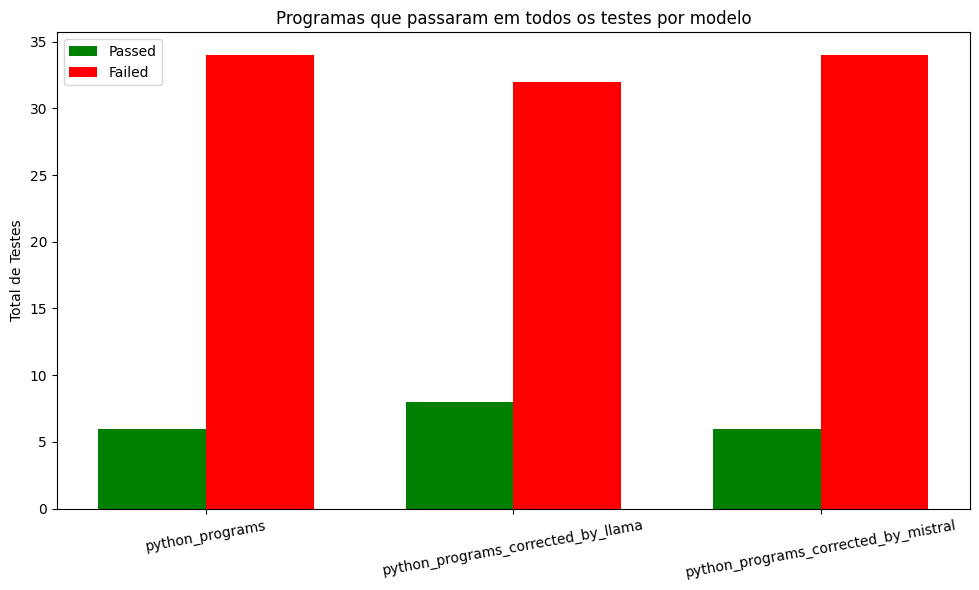

In [16]:
import matplotlib.pyplot as plt

labels = []
passed_counts = []
failed_counts = []

for programs, test_file in resultados.items():
    passed = 0
    failed = 0
    for result in test_file.values():
        if result['passed'] > 0 and result['failed'] == 0 and result['error'] == 0:
            passed += 1
        else:
            failed += 1
    labels.append(programs)
    passed_counts.append(passed)
    failed_counts.append(failed)

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, passed_counts, width, label='Passed', color='green')
plt.bar([i + width for i in x], failed_counts, width, label='Failed', color='red')

plt.ylabel('Total de Testes')
plt.title('Programas que passaram em todos os testes por modelo')
plt.xticks([i + width / 2 for i in x], labels, rotation=10)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
import csv

chaves = ['python_programs', 'python_programs_corrected_by_mistral', 'python_programs_corrected_by_llama']

all_test_files = set()
for tests in resultados.values():
    all_test_files.update(tests.keys())

all_test_files = sorted(all_test_files)

with open('tabela_resultados.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['nome_arquivo', 'result_programs', 'result_mistral', 'result_llama'])
    
    for test_file in all_test_files:
        row = [test_file]
        for key in chaves:
            result = resultados.get(key, {}).get(test_file)
            if result and result['passed'] > 0 and result['failed'] == 0 and result['error'] == 0:
                row.append(1)
            else:
                row.append(0)
        writer.writerow(row)


In [18]:
from tabulate import tabulate

with open('tabela_resultados.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    table = list(reader)

headers = table[0]
rows = table[1:]

print(tabulate(rows, headers=headers, tablefmt="grid"))

+------------------------------------+-------------------+------------------+----------------+
| nome_arquivo                       |   result_programs |   result_mistral |   result_llama |
+====================================+===================+==================+================+
| test_bitcount.py                   |                 0 |                0 |              1 |
+------------------------------------+-------------------+------------------+----------------+
| test_breadth_first_search.py       |                 0 |                0 |              1 |
+------------------------------------+-------------------+------------------+----------------+
| test_bucketsort.py                 |                 0 |                0 |              0 |
+------------------------------------+-------------------+------------------+----------------+
| test_depth_first_search.py         |                 0 |                0 |              0 |
+------------------------------------+------------

In [19]:
all_tests = set()
for key in resultados:
    all_tests.update(resultados[key].keys())

table = []
for test in sorted(all_tests):
    row = [test]
    for key in ['python_programs', 'python_programs_corrected_by_llama', 'python_programs_corrected_by_mistral']:
        vals = resultados.get(key, {}).get(test, {'failed': '-', 'passed': '-', 'error': '-'})
        row.append(f"F:{vals['failed']} P:{vals['passed']} E:{vals['error']}")
    table.append(row)

headers = ['Test', 'Original', 'Corrected by Llama', 'Corrected by Mistral']

print(tabulate(table, headers=headers, tablefmt='grid'))

+------------------------------------+--------------+----------------------+------------------------+
| Test                               | Original     | Corrected by Llama   | Corrected by Mistral   |
+====================================+==============+======================+========================+
| test_bitcount.py                   | F:0 P:0 E:0  | F:0 P:9 E:0          | F:0 P:0 E:0            |
+------------------------------------+--------------+----------------------+------------------------+
| test_breadth_first_search.py       | F:1 P:4 E:0  | F:0 P:5 E:0          | F:1 P:4 E:0            |
+------------------------------------+--------------+----------------------+------------------------+
| test_bucketsort.py                 | F:1 P:6 E:0  | F:0 P:0 E:2          | F:1 P:6 E:0            |
+------------------------------------+--------------+----------------------+------------------------+
| test_depth_first_search.py         | F:3 P:2 E:0  | F:1 P:4 E:0          | F:3 P

In [20]:
test_files = [
    'test_wrap.py',
    'test_lis.py',
    'test_flatten.py',
    'test_reverse_linked_list.py',
    'test_levenshtein.py',
    'test_find_in_sorted.py',
    'test_minimum_spanning_tree.py',
    'test_quicksort.py',
    'test_possible_change.py',
    'test_to_base.py',
    'test_shortest_path_length.py',
    'test_is_valid_parenthesization.py',
    'test_sqrt.py',
    'test_kth.py',
    'test_next_palindrome.py',
    'test_next_permutation.py',
    'test_rpn_eval.py',
    'test_find_first_in_sorted.py',
    'test_sieve.py',
    'test_shortest_path_lengths.py',
    'test_get_factors.py',
    'test_lcs_length.py',
    'test_subsequences.py',
    'test_gcd.py',
    'test_hanoi.py',
    'test_breadth_first_search.py',
    'test_kheapsort.py',
    'test_shunting_yard.py',
    'test_powerset.py',
    'test_detect_cycle.py',
    'test_pascal.py',
    'test_bitcount.py',
    'test_knapsack.py',
    'test_bucketsort.py',
    'test_max_sublist_sum.py',
    'test_shortest_paths.py',
    'test_mergesort.py',
    'test_longest_common_subsequence.py',
    'test_depth_first_search.py',
    'test_topological_ordering.py',
]


In [21]:
models = list(resultados.keys())
metrics = ['passed', 'failed', 'error']

totais_por_modelo = {}

for model in models:
    totais = {metric: 0 for metric in metrics}
    for f in test_files:
        for metric in metrics:
            totais[metric] += resultados[model][f][metric]
    totais_por_modelo[model] = totais

for model, totals in totais_por_modelo.items():
    print(f"Modelo: {model}")
    for metric, total in totals.items():
        print(f"  {metric}: {total}")
    print()


Modelo: python_programs
  passed: 110
  failed: 135
  error: 6

Modelo: python_programs_corrected_by_llama
  passed: 93
  failed: 165
  error: 4

Modelo: python_programs_corrected_by_mistral
  passed: 110
  failed: 135
  error: 6



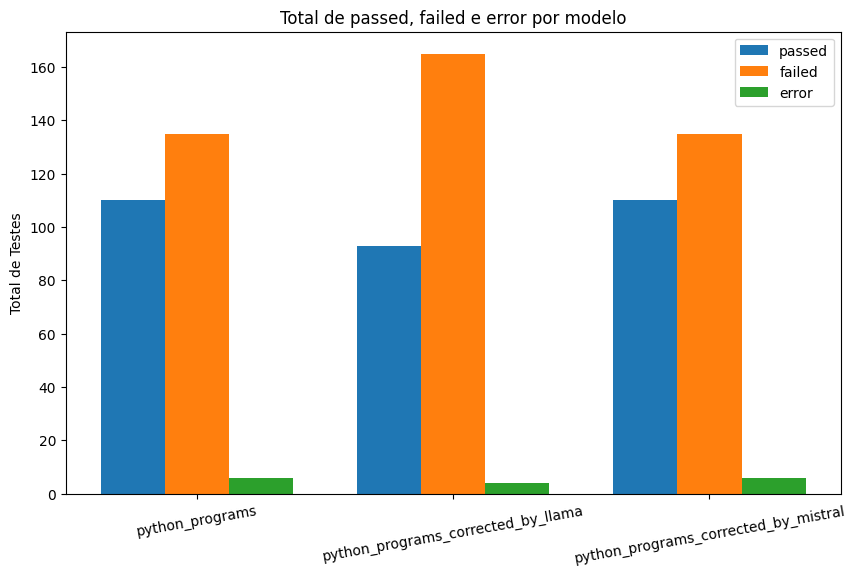

In [22]:
import matplotlib.pyplot as plt
import numpy as np

models = list(totais_por_modelo.keys())
metrics = ['passed', 'failed', 'error']

# Construir os dados para o gráfico
data = []
for metric in metrics:
    data.append([totais_por_modelo[model][metric] for model in models])

x = np.arange(len(models))  # posições no eixo x
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, data[i], width, label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=10)
ax.set_ylabel('Total de Testes')
ax.set_title('Total de passed, failed e error por modelo')
ax.legend()
plt.show()


In [23]:
resultados

{'python_programs': {'test_wrap.py': {'failed': 5, 'passed': 0, 'error': 0},
  'test_lis.py': {'failed': 4, 'passed': 8, 'error': 0},
  'test_flatten.py': {'failed': 0, 'passed': 7, 'error': 0},
  'test_reverse_linked_list.py': {'failed': 2, 'passed': 1, 'error': 0},
  'test_levenshtein.py': {'failed': 5, 'passed': 1, 'error': 0},
  'test_find_in_sorted.py': {'failed': 2, 'passed': 5, 'error': 0},
  'test_minimum_spanning_tree.py': {'failed': 3, 'passed': 0, 'error': 0},
  'test_quicksort.py': {'failed': 1, 'passed': 12, 'error': 0},
  'test_possible_change.py': {'failed': 9, 'passed': 1, 'error': 0},
  'test_to_base.py': {'failed': 7, 'passed': 3, 'error': 0},
  'test_shortest_path_length.py': {'failed': 2, 'passed': 2, 'error': 0},
  'test_is_valid_parenthesization.py': {'failed': 1, 'passed': 2, 'error': 0},
  'test_sqrt.py': {'failed': 7, 'passed': 0, 'error': 0},
  'test_kth.py': {'failed': 0, 'passed': 7, 'error': 0},
  'test_next_palindrome.py': {'failed': 1, 'passed': 4, 'error

### Funções de processamento Java

In [24]:
from pathlib import Path

def modify_package_files_java(generated_code_dir: Path):
    test_files = list(generated_code_dir.glob("*.java"))

    for test_file in test_files:
        original_code = test_file.read_text(encoding="utf-8")

        modified_code = re.sub(
            r"package java_programs(\w*);",
            rf"package {generated_code_dir.name};",
            original_code
        )

        test_file.write_text(modified_code, encoding="utf-8")

def compile_java_files(java_src_dir: Path, output_dir: Path, classpath: str = None, ignore_files=None):
    output_dir.mkdir(parents=True, exist_ok=True)
    
    if ignore_files is None:
        ignore_files = set()
    else:
        ignore_files = set(ignore_files)
    
    java_files = list(java_src_dir.glob("**/*.java"))
    
    java_files = [f for f in java_files if str(f) not in ignore_files and f.name not in ignore_files]
    
    if not java_files:
        print("Nenhum arquivo Java para compilar após ignorar arquivos listados.")
        return False
    
    javac_command = ["javac", "-d", str(output_dir)]
    if classpath:
        javac_command += ["-classpath", classpath]
    
    javac_command += [str(f) for f in java_files]
    
    result = subprocess.run(javac_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    if result.returncode != 0:
        print("Erro na compilação Java:")
        print(result.stderr)
        return False
    return True



In [42]:
ignore_files_java_llama = [
    "QuixBugs/java_programs_corrected_by_llama/NEXT_PALINDROME.java",
    "QuixBugs/java_programs_corrected_by_llama/DEPTH_FIRST_SEARCH.java",
]

ignore_files_java_mistral = [
    "QuixBugs/java_programs_corrected_by_mistral/SHORTEST_PATHS.java",
    "QuixBugs/java_programs_corrected_by_mistral/GET_FACTORS.java",
]


In [46]:
modify_package_files_java(java_output_mistral_dir)
compile_java_files(java_output_mistral_dir, java_output_mistral_dir, ignore_files=ignore_files_java_mistral)

Erro na compilação Java:
QuixBugs/java_programs_corrected_by_mistral/IS_VALID_PARENTHESIZATION.java:12: error: class IS_VALID_PARENTHISIZATION is public, should be declared in a file named IS_VALID_PARENTHISIZATION.java
public class IS_VALID_PARENTHISIZATION {
       ^
QuixBugs/java_programs_corrected_by_mistral/LEVENSHTEIN.java:8: error: class Levenshtein is public, should be declared in a file named Levenshtein.java
public class Levenshtein {
       ^
QuixBugs/java_programs_corrected_by_mistral/NEXT_PALINDROME.java:15: error: incompatible types: possible lossy conversion from double to int
        int high_mid = Math.ceil((double) digit_list.length / 2);
                                ^
QuixBugs/java_programs_corrected_by_mistral/NEXT_PALINDROME.java:16: error: incompatible types: possible lossy conversion from double to int
        int low_mid = Math.ceil((double) digit_list.length / 2) - 1;
                                                                ^
QuixBugs/java_programs_co

False